In [9]:
import pandas as pd
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt

Data = "customer_behavior.csv"
DataFlow = pd.read_csv(Data)
DataFlow = DataFlow.rename(columns=lambda c: c.strip())
DataFlow["PurchaseAmount"] = pd.to_numeric(DataFlow["PurchaseAmount"], errors="coerce")
for col in ["Gender","Region","ProductCategory","Churn","CampaignGroup"]:
    if col in DataFlow.columns:
        DataFlow[col] = DataFlow[col].astype(str).str.strip()
print(DataFlow.head())
print("\n Shape :", DataFlow.shape)

   CustomerID  Gender Region  PurchaseAmount ProductCategory Churn  \
0        1001    Male  South          256.07         Fashion    No   
1        1002  Female  South             NaN     Electronics   Yes   
2        1003  Female   West         1194.41         Fashion    No   
3        1004  Female  South          413.06         Grocery    No   
4        1005    Male   West         1556.32         Fashion   Yes   

  CampaignGroup  
0             A  
1             B  
2             A  
3             A  
4             A  

 Shape : (5000, 7)


In [14]:
def SafeMode(series: pd.Series):
    m = series.mode(dropna=True)
    if m.empty:
        return np.nan
    return m.iloc[0]


In [18]:
Purchase = DataFlow["PurchaseAmount"].dropna()
MeanValue = Purchase.mean()
MedianValue = Purchase.median()
ModeValue = SafeMode(Purchase.round(2))

print("Mean   :", round(MeanValue,2))
print("Median :", round(MedianValue,2))
print("Mode   :", round(ModeValue,2) if pd.notna(ModeValue) else "No unique mode")

print("\n If Mean > Median, distribution may be right‑skewed.")

Mean   : 1003.95
Median : 998.08
Mode   : 0.0

 If Mean > Median, distribution may be right‑skewed.


In [20]:
def IQR_outlier_bounds(series: pd.Series):
    S = series.dropna()
    import numpy as np
    Q1, Q3 = np.percentile(S, [25, 75])
    IQR = Q3 - Q1
    Lower = Q1 - 1.5 * IQR
    Upper = Q3 + 1.5 * IQR
    return Q1, Q3, IQR, Lower, Upper


In [47]:
Q1, Q3, IQR, Lower, Upper = IQR_outlier_bounds(DataFlow["PurchaseAmount"])
Outliers = DataFlow[(DataFlow["PurchaseAmount"] < Lower) | (DataFlow["PurchaseAmount"] > Upper)][["CustomerID","PurchaseAmount"]]

print(f"Q1={Q1:,.2f}, Q3={Q3:,.2f}, IQR={IQR:,.2f}")
print(f"Lower fence={Lower:,.2f}, Upper fence={Upper:,.2f}")
print("Outlier count:", len(Outliers))
Outliers.head(10)

Q1=673.64, Q3=1,327.08, IQR=653.44
Lower fence=-306.51, Upper fence=2,307.23
Outlier count: 15


,CustomerID,PurchaseAmount
195,1196,2318.33
265,1266,2496.41
348,1349,2688.69
411,1412,2349.16
826,1827,2578.89
1358,2359,2384.19
2285,3286,2457.05
2557,3558,2316.19
2681,3682,2400.69
3326,4327,2357.41


In [26]:
Skew = stats.skew(Purchase, bias=False, nan_policy="omit")
KurtFisher = stats.kurtosis(Purchase, fisher=True, bias=False, nan_policy="omit")
print(f"Skewness : {Skew:,.3f}  (Condition: If >0 Right‑skew, <0 Left‑skew)")
print(f"Kurtosis : {KurtFisher:,.3f}  (Condition: 0≈normal, >0 leptokurtic, <0 platykurtic)")


Skewness : 0.106  (Condition: If >0 Right‑skew, <0 Left‑skew)
Kurtosis : -0.262  (Condition: 0≈normal, >0 leptokurtic, <0 platykurtic)


In [56]:
Male = DataFlow.loc[DataFlow["Gender"]=="Male","PurchaseAmount"].dropna()
Female = DataFlow.loc[DataFlow["Gender"]=="Female","PurchaseAmount"].dropna()

print("Counts — Male:", len(Male), "Female:", len(Female))

lev_stat, lev_p = stats.levene(Male, Female, center="median")
t_stat, p_val = stats.ttest_ind(Male, Female, equal_var=False, nan_policy="omit")

print(f"Variance equality test: Levene p={lev_p:,.4f}  ")
print(f"Welch t-test: t={t_stat:,.3f}, p={p_val:,.4f}")
print("Interpretation: p<0.05 ⇒ significant difference in mean spending.")

Counts — Male: 2386 Female: 2370
Variance equality test: Levene p=0.4973  
Welch t-test: t=2.235, p=0.0255
Interpretation: p<0.05 ⇒ significant difference in mean spending.


**Assumptions**
-  Statistically there is having significant difference in spending between Male and Female.

In [50]:
CT = pd.crosstab(DataFlow["ProductCategory"], DataFlow["Churn"])
chi2, p, dof, expected = stats.chi2_contingency(CT)
print(CT)
print(f"\nChi square test={chi2:,.3f}, \nDegrees of freedom={dof},\np-Value={p:,.4f}")
print("Interpretation: p<0.05 ⇒ evidence of association between category and churn.")

Churn             No  Yes  nan
ProductCategory               
Electronics      785  541   77
Fashion          839  607   77
Grocery          855  604   89
nan              313  191   22

Chi square test=4.929, 
Degrees of freedom=6,
p-Value=0.5529
Interpretation: p<0.05 ⇒ evidence of association between category and churn.


**Assumptions**
-  Here P-Value is greater than 0.05, So No evidence of an association between ProductCategory and Churn. 

In [52]:
Groups = [g.dropna().values for _, g in DataFlow.groupby("Region")["PurchaseAmount"]]
Labels = list(DataFlow.groupby("Region").groups.keys())

lev_stat, lev_p = stats.levene(*Groups, center="median")
f_stat, p_val = stats.f_oneway(*Groups)
h_stat, h_p = stats.kruskal(*Groups)

print("Regions:", Labels)
print(f"Levene p={lev_p:,.4f}")
print(f"ANOVA  F={f_stat:,.3f}, p={p_val:,.4f}")
print(f"Kruskal H={h_stat:,.3f}, p={h_p:,.4f}")
print("Interpretation: ANOVA p<0.05 ⇒ at least one region mean differs; consider post‑hoc tests.")

Regions: ['East', 'North', 'South', 'West', 'nan']
Levene p=0.2644
ANOVA  F=0.293, p=0.8825
Kruskal H=1.093, p=0.8955
Interpretation: ANOVA p<0.05 ⇒ at least one region mean differs; consider post‑hoc tests.


**Assumptions**
-  Based on the both tests, It clearly indicates that PurchaseAmount does not differ by Region.

In [53]:
A = DataFlow.loc[DataFlow["CampaignGroup"].str.upper()=="A","PurchaseAmount"].dropna()
B = DataFlow.loc[DataFlow["CampaignGroup"].str.upper()=="B","PurchaseAmount"].dropna()

Mean_A, Mean_B = A.mean(), B.mean()
t_stat, p_val = stats.ttest_ind(A, B, equal_var=False, nan_policy="omit")
better = "A" if Mean_A > Mean_B else "B"

print(f"Mean A: {Mean_A:,.2f} | Mean B: {Mean_B:,.2f}")
print(f"Welch t-test: t={t_stat:,.3f}, p={p_val:,.3f}")
print(f"Higher average PurchaseAmount: Campaign {better}")

Mean A: 1,011.95 | Mean B: 994.34
Welch t-test: t=1.243, p=0.214
Higher average PurchaseAmount: Campaign A


Shapiro–Wilk: W=0.995, p=0.0000  (p≥0.05 suggests normality)


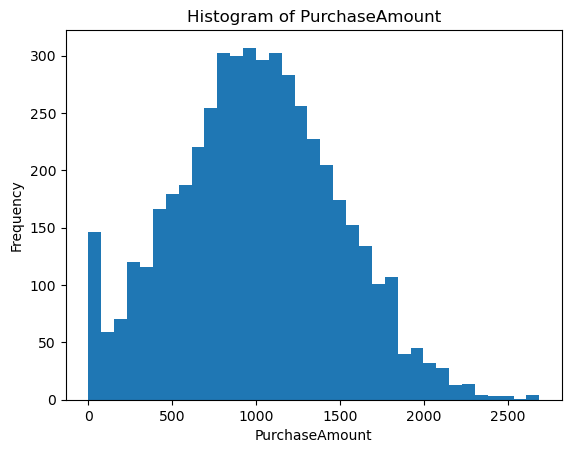

In [54]:
Sample = DataFlow["PurchaseAmount"].dropna().sample(n=min(5000, DataFlow["PurchaseAmount"].dropna().shape[0]), random_state=42)
W, p_shapiro = stats.shapiro(Sample)
print(f"Shapiro–Wilk: W={W:,.3f}, p={p_shapiro:,.4f}  (p≥0.05 suggests normality)")

plt.hist(DataFlow["PurchaseAmount"].dropna(), bins='auto')
plt.title("Histogram of PurchaseAmount")
plt.xlabel("PurchaseAmount"); plt.ylabel("Frequency")
plt.show()


**Assumptions**
- Based on Shapiro-Wilk test means we can't reject normality at α = 0.05.
- The histogram looks roughly bell shaped with only a mild right tail. So we can say it approximately follows a normal distribution.

Mean of sample means: 1,004.30
Std of sample means : 68.71  (≈ σ/√n)


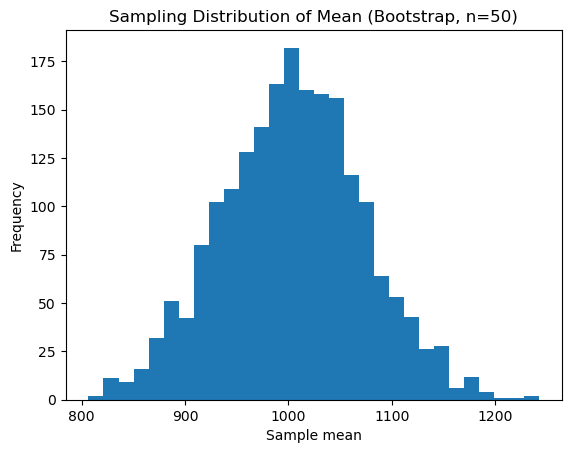

In [42]:
np.random.seed(42)
S = DataFlow['PurchaseAmount'].dropna().values
SampleSize = 50
n_boot = 2000
Means = [np.mean(np.random.choice(S, size=SampleSize, replace=True)) for _ in range(n_boot)]
Means = np.array(Means)

print(f"Mean of sample means: {Means.mean():,.2f}")
print(f"Std of sample means : {Means.std(ddof=1):,.2f}  (≈ σ/√n)")

plt.hist(Means, bins='auto')
plt.title("Sampling Distribution of Mean (Bootstrap, n=50)")
plt.xlabel("Sample mean") 
plt.ylabel("Frequency")
plt.show()

**Assumptions**
- Sampling distribution is Approximately normal.
- Sample Mean is an unbiased estimator of the population mean.
- PurchaseAmount has a finite variance.

In [55]:
Purchase = DataFlow['PurchaseAmount'].dropna()
n = len(Purchase)
Mean_x = Purchase.mean()
Std = Purchase.std(ddof=1)
se = Std / math.sqrt(n)
t_crit = stats.t.ppf(1 - 0.05/2, df=n-1)
Lo, Up = Mean_x - t_crit*se, Mean_x + t_crit*se

print(f"n={n}, mean={Mean_x:,.2f}, Std={Std:,.2f}, SE={se:,.2f}, t*={t_crit:,.3f}")
print(f"95% CI: [{Lo:,.2f}, {Up:,.2f}]")

n=4850, mean=1,003.95, Std=482.11, SE=6.92, t*=1.960
95% CI: [990.38, 1,017.52]


**Assumptions**
-  Each Purchase is approximately independent